# Computer Vision Assignment 1 Part 2
---

Semester: **Fall 2022**

Due date: **September 29th 2022, 11.59PM EST.**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2022/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95% 

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard. 

# Dataset Preparation
___

1.  Download `dataset.zip` from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`. 
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it. 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/cv_kaggle_assignment/

Mounted at /content/drive
/content/drive/My Drive/cv_kaggle_assignment


# Dataloader

In [2]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 64
momentum = 0.9
lr = 1e-3 # set lr to default 1e-3 for optimizer Adam
epochs = 80
log_interval = 100

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1,pin_memory =True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1,pin_memory =True)

# Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

nclasses = 43 # GTSRB has 43 classes


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size = 4)
        self.conv2 = nn.Conv2d(96, 256, kernel_size = 4)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(256, 384, kernel_size = 4)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(384, 200)
        self.fc2 = nn.Linear(200, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.to('cuda')), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:       # Get the products
            num_features *= s
        return num_features


 
### A brief description:
 1. the Model Design

    The selection of parameters is mainly based on the reference 1.
    
    Layer 1:
    - 4x4 Conv C_in = 3, C_out = 96
    - 2x2 MaxPool
    - ReLU
    
    Layer 2:
    - 4x4 Conv C_in = 96, C_out = 256
    - 2x2 MaxPool
    - ReLU, Dropout2d
    
    Layer 3:
    - 4x4 Conv C_in = 256, C_out = 384
    - 2x2 MaxPool
    - ReLU, Dropout2d
  
    Linear layer with 200 hidden units.

    Linear layer to 43 output units.

    Train it for 80 epochs.



            Conv2d-1           [-1, 96, 29, 29]           4,704
            Conv2d-2          [-1, 256, 11, 11]         393,472
         Dropout2d-3          [-1, 256, 11, 11]               0
            Conv2d-4            [-1, 384, 2, 2]       1,573,248
         Dropout2d-5            [-1, 384, 2, 2]               0
            Linear-6                  [-1, 200]          77,000
            Linear-7                   [-1, 43]           8,643
 
 2. Optimizer
    
    Choose **Adam** as the Optimizer and set **learnig rate** to **1e-3** and **weight_decay** as **0.0005** at the first, based on reference 4.

    (After testing, the effect of Adam is better than SDG for this model.)

    https://pytorch.org/docs/stable/optim.html#

3.  Learnig Rate Adjustment
    
    Based on the reference 2, in the process of training the model, the learning rate should change accordingly. First set a default learning rate, and then adjust it according to the training situation. The initial learning rate is best set between 0.1 - 0.001.

    Use the `torch.optim.lr_scheduler` to adjust learning rate. 
    
    Most learning rate schedulers can be called back-to-back (also referred to as chaining schedulers). The result is that each scheduler is applied one after the other on the learning rate obtained by the one preceding it.
    
    https://pytorch.org/docs/stable/optim.html#



---

### Reference:

1.   Zeiler, M.D., Fergus, R. (2014). Visualizing and Understanding Convolutional Networks. In: Fleet, D., Pajdla, T., Schiele, B., Tuytelaars, T. (eds) Computer Vision – ECCV 2014. ECCV 2014. Lecture Notes in Computer Science, vol 8689. Springer, Cham. https://doi.org/10.1007/978-3-319-10590-1_53
2.   Smith, L. N. (2015). Cyclical Learning Rates for Training Neural Networks. arXiv. https://doi.org/10.48550/arXiv.1506.01186

3. Basic Training Framework Introduction: https://github.com/niemand-01/ML-Demo/wiki/pytorch%E8%AE%AD%E7%BB%83%E7%9A%84%E5%9F%BA%E6%9C%AC%E6%A1%86%E6%9E%B6

4. Blog about experience of optimizer adjusting: https://www.cnblogs.com/jfdwd/p/11239564.html

5. Fix Errors: https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte


# Training

In [8]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-06, weight_decay= 0.0005)

def train(epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.to('cuda')
        target=target.to('cuda')
        
        optimizer.zero_grad()
        output = model(data)
        train_loss = F.nll_loss(output, target)
        train_loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)# get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        training_accuracy = 100. * correct / len(train_loader.dataset)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()))
    return train_loss.item(), training_accuracy

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data=data.to('cuda')
        target=target.to('cuda')
        
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    validation_accuracy = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss, validation_accuracy

def todevice(data, d):
    nt=[]
    if (type(data))==(list,tuple):
        for i in data: nt.append(todevice(i))
        print(nt)
    else: print( data.to(d, non_blocking=True) )
todevice(model, 'cuda')

Net(
  (conv1): Conv2d(3, 96, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(4, 4), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(256, 384, kernel_size=(4, 4), stride=(1, 1))
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=384, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=43, bias=True)
)


In [5]:
import matplotlib.pyplot as plt

In [9]:
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

training_loss_log = []
training_accuracy_log = []
validation_loss_log = []
validation_accuracy_log = []

for epoch in range(1, epochs + 1):
    training_loss, training_accuracy = train(epoch)
    validation_loss, validation_accuracy = validation()

    training_loss_log.append(training_loss)
    training_accuracy_log.append(training_accuracy)
    validation_loss_log.append(validation_loss)
    validation_accuracy_log.append(validation_accuracy)

    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')
    scheduler1.step()
    scheduler2.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.784394
Train Epoch: 1 [6400/35339 (18%)]	Loss: 2.892824
Train Epoch: 1 [12800/35339 (36%)]	Loss: 1.911670
Train Epoch: 1 [19200/35339 (54%)]	Loss: 1.586395
Train Epoch: 1 [25600/35339 (72%)]	Loss: 1.196399
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.561193

Validation set: Average loss: 0.9320, Accuracy: 2913/3870 (75%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.660457
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.535216
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.437605
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.471127
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.153232
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.280446

Validation set: Average loss: 0.3410, Accuracy: 3576/3870 (92%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.203740
Train Epoch: 3 [6400/35339 (18%)]	Loss: 0.305540
Train Epoch: 3 [12800/35339 (36%)]	Loss: 0.125530
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.219753
Train Epoch: 3 [25600/35339 

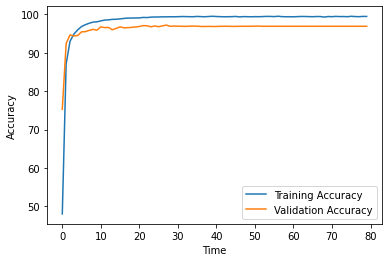

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
time = list(range(80))

plt.plot(time,training_accuracy_log)
plt.plot(time,validation_accuracy_log)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylabel(u'Accuracy')
plt.xlabel(u'Time')

plt.show()

In [16]:
import torchvision.models as models
from torchsummary import summary
summary(model.cuda(), input_size=(3, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 29, 29]           4,704
            Conv2d-2          [-1, 256, 11, 11]         393,472
         Dropout2d-3          [-1, 256, 11, 11]               0
            Conv2d-4            [-1, 384, 2, 2]       1,573,248
         Dropout2d-5            [-1, 384, 2, 2]               0
            Linear-6                  [-1, 200]          77,000
            Linear-7                   [-1, 43]           8,643
Total params: 2,057,067
Trainable params: 2,057,067
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.11
Params size (MB): 7.85
Estimated Total Size (MB): 8.97
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Evaluate and Submit to Kaggle



In [17]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model.eval() # Don't forget to put your model on eval mode !

if torch.cuda.is_available():
    model.cuda()

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    model.to('cuda')
    data = data.to('cuda')
    output = model(data)
    output.to('cuda')
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.

**Extra important:** Please use your NYU NetID as your team name on Kaggle, or your submissions will not be evaluated.  
You can rename your team easily from the Team tab: https://www.kaggle.com/competitions/nyu-computer-vision-csci-ga2271-2022/team.